# Classifying Images as Birds or Airplanes


**Dataset:** https://www.cs.toronto.edu/~kriz/cifar.html<br>


More writeup stuff.
Must include learning objectives, explainations of similar work, how my work differs etc. 
probably do an abstract to explain this project as well.

## Import required libraries

PyTorch for building and training the neural network.

In [102]:
import torch

Torchvision

In [103]:
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset


Numpy for data manipulation and preprocessing

In [104]:
import matplotlib.pyplot as plt

In [105]:
import numpy as np

## Data Pre-processing

### Loading and transforming the data

First we can define a transform for the image data we are about to import, turning them into tensors. We do this so [INSERT REASON HERE]. This also has the benefit of automatically normalising us from a range from 0-255, which while not necessary for image data, is worth doing for advantages such as faster training.
[SOURCE: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/].

In [106]:
transform = transforms.Compose(
    [transforms.ToTensor()])

Next we load the train and test dataset from the CIFAR-10, while also applying the transform:

In [107]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


Files already downloaded and verified


Now we can view the properties of the datasets we have imported:

In [108]:
print("Train-set size:", len(trainset))
print("Test-set size:", len(testset))
print("Classes: ", trainset.classes)

Train-set size: 50000
Test-set size: 10000
Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


As the CIFAR-10 dataset has already sorted the dataset into training and testing automatically we do not need to worry about this. It has a test to train ratio of 5:1

### Filtering the data

As we can see, this dataset currently consists of 10 seperate classes, while we only want to classify between airplanes and birds. For this reason, we will filter out the other classes:

In [109]:
#0 and 2 correspond to the index of the 'airplane' and 'bird' classes
filtered_classes = [0, 2]

train_indices = [i for i, label in enumerate(trainset.targets) if label in filtered_classes]
test_indices = [i for i, label in enumerate(testset.targets) if label in filtered_classes]

trainset_filtered = torch.utils.data.Subset(trainset, train_indices)
testset_filtered = torch.utils.data.Subset(testset, test_indices)

Upon filtering the dataset, we can view the properties of the new subset below. Notice how the train and test sets have shrunk to 20% of the original size, as we have removed the 80% we are not using.

In [110]:
print("Train-set size:", len(trainset_filtered))
print("Test-set size:", len(testset_filtered))
print([trainset.classes[i] for i in filtered_classes])


Train-set size: 10000
Test-set size: 2000
['airplane', 'bird']


### Viewing the data

Next we can observe the images and labels in this dataset to ensure that it is working as expected.

Bird label:  2


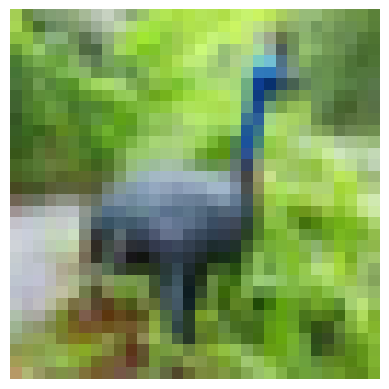

Plane label:  0


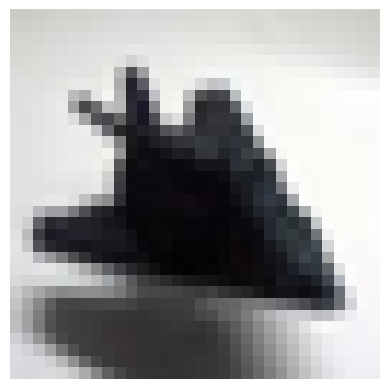

In [111]:
#1st bird in the data set
bird_image, bird_label = trainset_filtered[0]
print("Bird label: ", bird_label)
plt.imshow(bird_image.permute(1,2,0))
plt.axis('off')
plt.show()

#1st plane in the dataset
plane_image, plane_label = trainset_filtered[4]
print("Plane label: ", plane_label)
plt.imshow(plane_image.permute(1,2,0))
plt.axis('off')
plt.show()

As we can see label 2 is linked with the bird label, and label 0 is linked with the planes image, as expected.

### Creating dataloaders

Next we must create dataloaders, so we can have an iterable over our dataset:

In [153]:
trainloader = torch.utils.data.DataLoader(trainset_filtered, batch_size=4, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset_filtered, batch_size=4, shuffle=False, num_workers=4)

We should also have class labels for our invididual classes to be distinguished. In this case, it is 'bird' and 'airplane' which can be configured as follows:

In [113]:
classes = {'bird', 'airplane'}

We shuffle the data in our training dataset. This is to make sure that the model doesn't learn anything from the order of images input. This isn't necessary with our testing dataset however, so we can leave this false. 
Num_workers relates to the number seperate workers that will load the data in parallel. While a high number of workers may speed up performance, it may also increase memory utilisation so its good to strike a balance.
We are also using a batch size of 4. A larger batch size can be good for speed, but too high and we risk lower accuracy and overfitting.

## Defining the Model

In [114]:
for i, (x_train, y_train) in enumerate(trainset_filtered):
    break

In [115]:
x_train.shape

torch.Size([3, 32, 32])

Testing neural net stuff

In [116]:
conv1 = nn.Conv2d(3,6,4,1)

In [117]:
x = x_train.view(1,3,32,32)
x.shape

torch.Size([1, 3, 32, 32])

In [118]:
x = F.relu(conv1(x))

In [119]:
x.shape

torch.Size([1, 6, 29, 29])

In [120]:
x = F.max_pool2d(x, 2, 2)

In [121]:
x.shape

torch.Size([1, 6, 14, 14])

In [122]:
conv2 = nn.Conv2d(6,16,4,1)

In [123]:
x = F.relu(conv2(x))

In [124]:
x.shape

torch.Size([1, 16, 11, 11])

In [125]:
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 16, 5, 5])

Next we must define a model, which we are doing with a Convolutional Neural Network as these are very good for classifying images.

A convolution neural network has many different layers. These include, convolutional, pooling and fully connected layers that take the following parameters:
Convolutional(
    Input
    Output
    Kernel Size
    Stride
    )
Pooling(
    X
    Y
    Z)
Fully Connected Layer(
    Kernel Size
    Stride
)

Rather than redefining our pooling layer, as we want one of the same size so we can just call it twice

In [149]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #Convoliton layers
        self.conv1 = nn.Conv2d(3,16,5,1)
        self.conv2 = nn.Conv2d(16,32,5,1)
        #Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        #Fully connected layers
        self.fc1 = nn.Linear(32 * 5 * 5, 120) #32*5*5 output channel * batch size * batch size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,2) #2 outputs, for our 2 classifiers. Bird and Airplane

    #Progress across model    
    def forward(self, x):
        print("x size:", x.size())
        x = nn.functional.relu(self.conv1(x))
        print("x size:", x.size())
        x = self.pool(x)
        print("x size:", x.size())
        x = nn.functional.relu(self.conv2(x))
        print("x size:", x.size())

        x = x.view(-1, 32*5*5) #Total number of elements in tensor
        print("x size after resize:", x.size())
        x = nn.functional.relu(self.fc1(x))
        print("x size:", x.size())
        x = nn.functional.relu(self.fc2(x))
        print("x size:", x.size())
        x = self.fc3(x)
        return x

model = Model()
model



Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

For our first convolution layer, we have an input of 3, as each image has 3 seperate inputs for different RGB channels

## Defining Model Hyperparameters

Explaination about hyperparameters

The loss function is what we use to calculate the error, quantifying the difference between the predicted output and the actual output. It helps us measure the performance of a model, while also indicating the direction to improve in.
For general image classification, you will likely want to use Cross-Entropy classification, however in our case as we only have 2 sets of images, we can use Binary Cross-Entrophy as follows:

In [152]:
loss_fn = nn.BCELoss()
for inputs, labels in trainloader:
    # Forward pass
    outputs = model(inputs)
    
    # Compute loss
    loss = loss_fn(outputs, labels)
    print('Total loss for this batch {}'.format(loss.item()))


x size: torch.Size([4, 3, 32, 32])
x size: torch.Size([4, 16, 28, 28])
x size: torch.Size([4, 16, 14, 14])
x size: torch.Size([4, 32, 10, 10])
x size after resize: torch.Size([16, 800])
x size: torch.Size([16, 120])
x size: torch.Size([16, 84])


ValueError: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([16, 2])) is deprecated. Please ensure they have the same size.

As for the optimiser, we will use the ADAM optimiser from PyTorch as it is a good, common optimiser for deep neural networks. [SOURCE: https://visualstudiomagazine.com/articles/2022/10/14/binary-classification-using-pytorch-2.aspx#:~:text=The%20two%20most%20common%20are,everything%20about%20every%20optimization%20algorithm.] We must also designate a learning rate. The smaller the learning rate, the slower it will be.

In [ ]:
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)

## Training the Model